In [1]:
import torch
import torchvision
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
random_seed = 1
torch.manual_seed(random_seed)

In [3]:
trainset = torchvision.datasets.MNIST('', train=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
testset = torchvision.datasets.MNIST('', train=False,transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
trainset, valset = torch.utils.data.random_split(trainset, [int(0.9 * len(trainset)), int(0.1 * len(trainset))])
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 32, 5, padding = 2)
        self.conv2 = nn.Conv2d(32, 32, 5, padding = 2)
        self.drop1 = nn.Dropout2d(p=0.25)
        self.max_pool = torch.nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding = 1)
        self.linear1 = nn.Linear(64*7*7, 512)
        self.drop2 = nn.Dropout2d(p=0.5)
        self.linear2 = nn.Linear(512, 10)
        self.log_softmax = nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.max_pool(x)
        x = self.drop1(x)

        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.max_pool(x)
        x = self.drop1(x)

        x = x.reshape(x.size (0), -1)
        x = self.relu(self.linear1(x))
        x = self.drop2(x)
        x = self.log_softmax(self.linear2(x))
        return x


In [5]:
def show_digit(images, lables,show, *option):  
    if show == 'digit':
        images = [(image,label) for (image,label) in zip(images,lables) if label == option[0]][0:option[1]]
        last = option[1]
    elif show == 'list':
        images = [(image,label) for (image,label) in zip(images,lables)][option[0]:option[1]]
        last = len(images)
    plt.figure(figsize=(2*len(images),2*len(images)))
    for index, (image,label) in enumerate(images):
            plt.subplot(1,last,index+1)
            plt.imshow(np.reshape(image,(28,28)), cmap=plt.cm.gray_r)
            plt.title(label, fontsize=10)


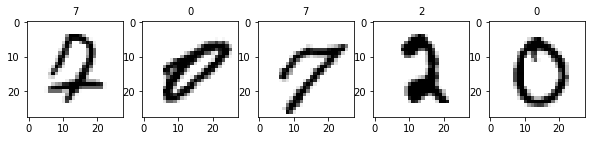

In [6]:
images = [torchvision.transforms.ToPILImage()(trainset[i][0]) for i in range (0,6)]
labels = [trainset[i][1] for i in range (0,6)]

show_digit(images,labels,'list',1,10)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network = Net()
network.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=0.01,momentum=0.5)
device

device(type='cuda', index=0)

In [8]:
n_epochs = 30
train_loss = list()
val_loss = list()

In [9]:
def train_epoch(network, optimizer, criterion,
                train_loader, val_loader, epoch):
    total_train_loss = 0
    total_val_loss = 0
    total_predict = 0
    for i, (data, target) in enumerate(train_loader):
        loss = train(network, optimizer, criterion, data, target)
        total_train_loss += loss
        print(f'Эпоха: {epoch} [{i * len(data)}/{len(train_loader.dataset)} ({100.*i * len(data)/len(train_loader.dataset):.0f}%)]', end='\r')
    total_train_loss = total_train_loss / (len(train_loader) + 1)
    train_loss.append(total_train_loss)
   
    for i, (data, target) in enumerate(val_loader):    
        predict, loss = validate(network, data, target)
        total_val_loss += loss
        total_predict += predict
    total_val_loss = total_val_loss / (len(val_loader) + 1)
    val_loss.append(total_val_loss)
    accuracy = float(total_predict.data)/len(val_loader.dataset)
    return total_train_loss, total_val_loss, accuracy
        
def train(network, optimizer, criterion, data, target):
    network.train(mode=True)
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    prediction = network(data)
    loss = criterion(prediction, target)
    loss.backward()
    optimizer.step()
    return loss.item()

def validate(network, data, target):
    network.train(mode=False)
    data = data.to(device)
    target = target.to(device)
    
    prediction = network(data)
    loss = criterion(prediction, target)
    prediction = prediction.data.max(1, keepdim=True)[1]
    return prediction.eq(target.data.view_as(prediction)).sum(), loss.item()

def test(network, data, target):
    data = data.to(device)
    target = target.to(device)
    prediction = network(data)
    prediction = prediction.data.max(1, keepdim=True)[1]
    return prediction.eq(target.data.view_as(prediction)).sum()

In [10]:
t1=time.time()
running_loss = 0.0
best_val_loss = 999
for epoch in range(1, n_epochs + 1):
    total_train_loss, total_val_loss, accuracy = train_epoch(network, optimizer, criterion, 
                train_dataloader, val_dataloader, epoch)
    print(f'Эпоха: {epoch}/{n_epochs}, Ошибка на трен.: {total_train_loss:.4f}, Ошибка на пров. {total_val_loss:.4f}, Точность на пров.: {accuracy:.4f}\n')
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print(f'Сохранение модели для эпохи {epoch} с ошибкой: {total_val_loss:.4f}')
        torch.save(network.state_dict(), 'model.pth')
        torch.save(optimizer.state_dict(), 'optimizer.pth')
t2=time.time()




Эпоха: 1/30, Ошибка на трен.: 0.7330, Ошибка на пров. 0.1080, Точность на пров.: 0.9662

Сохранение модели для эпохи 1 с ошибкой: 0.1080
Эпоха: 2/30, Ошибка на трен.: 0.1290, Ошибка на пров. 0.0678, Точность на пров.: 0.9793

Сохранение модели для эпохи 2 с ошибкой: 0.0678
Эпоха: 3/30, Ошибка на трен.: 0.0912, Ошибка на пров. 0.0531, Точность на пров.: 0.9823

Сохранение модели для эпохи 3 с ошибкой: 0.0531
Эпоха: 4/30, Ошибка на трен.: 0.0711, Ошибка на пров. 0.0428, Точность на пров.: 0.9862

Сохранение модели для эпохи 4 с ошибкой: 0.0428
Эпоха: 5/30, Ошибка на трен.: 0.0597, Ошибка на пров. 0.0405, Точность на пров.: 0.9865

Сохранение модели для эпохи 5 с ошибкой: 0.0405
Эпоха: 6/30, Ошибка на трен.: 0.0534, Ошибка на пров. 0.0424, Точность на пров.: 0.9867

Эпоха: 7/30, Ошибка на трен.: 0.0469, Ошибка на пров. 0.0344, Точность на пров.: 0.9887

Сохранение модели для эпохи 7 с ошибкой: 0.0344
Эпоха: 8/30, Ошибка на трен.: 0.0419, Ошибка на пров. 0.0399, Точность на пров.: 0.9885



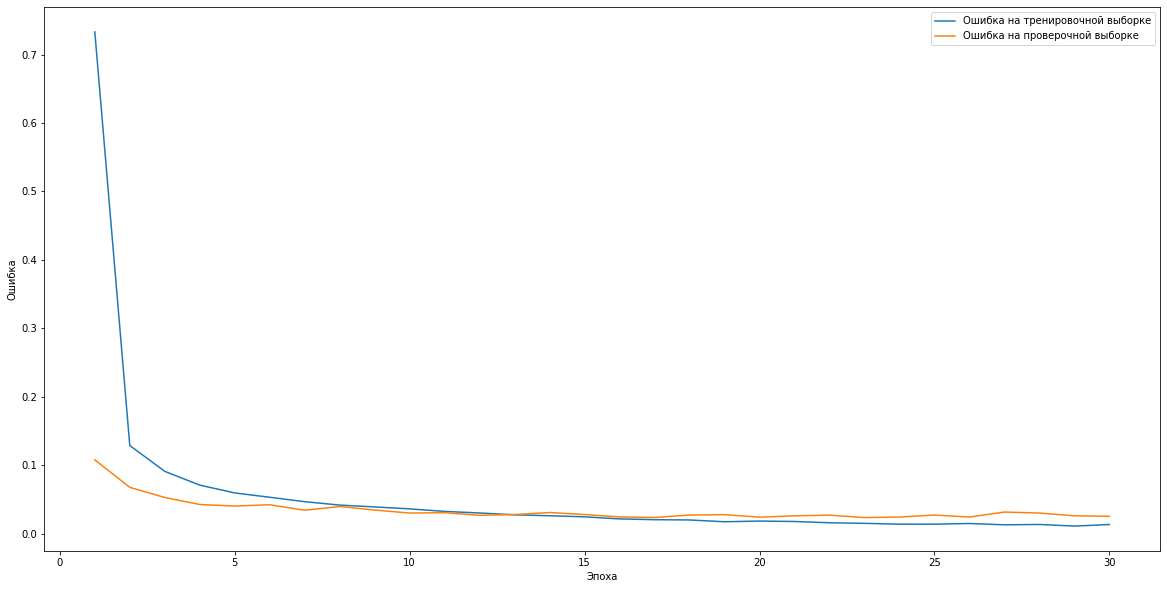

<Figure size 432x288 with 0 Axes>

In [11]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, n_epochs+1), train_loss, label="Ошибка на тренировочной выборке")
plt.plot(np.arange(1, n_epochs+1), val_loss, label="Ошибка на проверочной выборке")
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend(loc='upper right')
plt.show()
plt.savefig('loss.png')

In [15]:
network.load_state_dict(torch.load("model.pth"))
network.train(mode=False)
total_predict = 0
for i, (data, target) in enumerate(test_dataloader):    
    predict = test(network, data, target)
    total_predict += predict
print(f'Точность: {total_predict.data}/{len(test_dataloader.dataset)} [{100.*float(total_predict.data)/len(test_dataloader.dataset):.2f}%]')



Точность: 9928/10000 [99.28%]
